 # Energy Demand Prediction Using Advanced Time Series Methods
Energy consumption varies due to multiple factors: seasonality, day of the week, peak usage patterns, weather conditions, and more. Accurately forecasting future energy demand is essential to:

* Plan energy production and distribution.
* Stabilize the power grid and avoid unexpected peaks (blackouts or extra costs).
* Reduce carbon footprint by integrating renewable energy sources more efficiently and minimizing the use of pollutant sources.

**Main Objective**  
Develop one or more predictive models that can estimate future energy demand (e.g., for the following hours or days) with high accuracy

## Data Source 

- Electricity Load Diagrams 2011-2014 (UCI Machine Learning Repository)
- Source link: https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014
- Contains hourly electricity consumption data of 370 customers in Portugal, from 2011 to 2014.


## Library Imports

In [22]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For handling dates
import datetime

# For modeling
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Models
from xgboost import XGBRegressor

# Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# For interpretability
import shap


## Data Loading  
Placed dataset in a local directory called data/LD2011_2014.txt

In [25]:
# Load data
df = pd.read_csv(
    'data/LD2011_2014.txt', 
    sep=';', 
    index_col=0, 
    parse_dates=True, 
    decimal=','
)

print(df.shape)
df.head()


(140256, 370)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploration of dataset

In [30]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0 MB


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


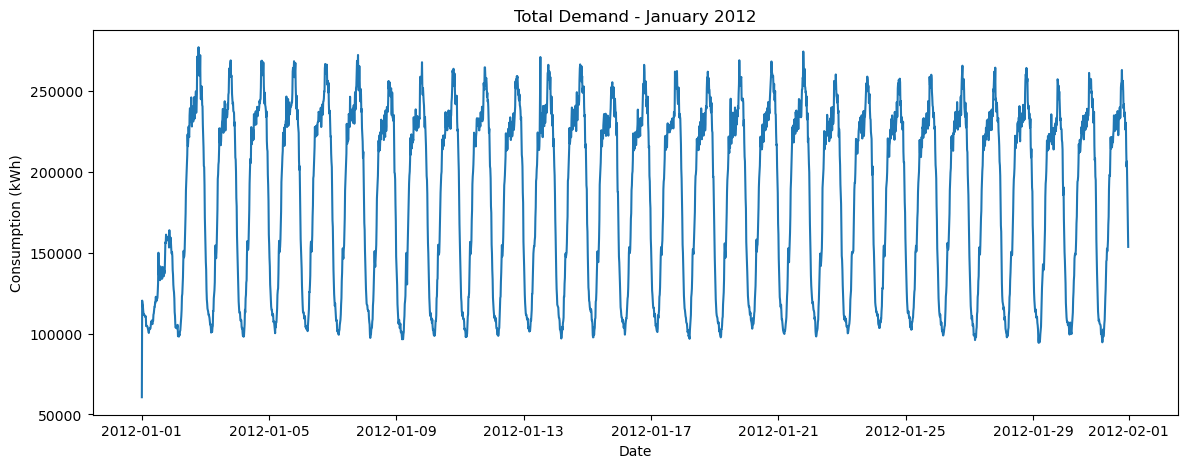

In [32]:
# Example: create a column with total demand across all customers
df['total_consumption'] = df.sum(axis=1)

# Let’s look at a short period, e.g., the first month of 2012
df_2012_jan = df.loc['2012-01':'2012-01']
plt.figure(figsize=(14,5))
plt.plot(df_2012_jan.index, df_2012_jan['total_consumption'])
plt.title("Total Demand - January 2012")
plt.xlabel("Date")
plt.ylabel("Consumption (kWh)")
plt.show()

## Data Preprocessing
- Check for missing values
- Interpolate or drop rows with missing data, depending on the situation.
- Adjust time frequency if needed. If we have one record per hour, we keep that frequency. If data is at 15-minute intervals, we may resample to hourly using df.resample('H').sum() or mean()
- Create a main series: we will focus on the total_consumption column to predict total demand.

In [40]:
# 1. Identify missing values
print(df['total_consumption'].isna().sum())

# 2. Interpolate if only a few are missing
df['total_consumption'] = df['total_consumption'].interpolate(method='time')

# 3. Ensure hourly frequency (if necessary)
df = df.asfreq('h', method='pad')

# 4. Filter down to the final column of interest
df_energy = df[['total_consumption']].copy()


0


## Feature Engineering
With Gradient Boosting, it is possible to create additional features based on the date index and the series itself:

- Lags: demand values from previous hours.
- Moving averages: average consumption for the last 24 hours, 7 days, etc.
- Calendar variables: hour of day, day of week, month, holidays, etc.
- Cyclical variables: represent the hour of day, day of the week, etc., using sine/cosine to capture periodicity.

In [44]:
def create_features(df, lags=[1,24,48,168]):
    """
    Creates lag columns and calendar features.
    lags: list of hourly lags (e.g., 1, 24,...)
    """
    df_feat = df.copy()
    
    # Lags
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['total_consumption'].shift(lag)
    
    # Calendar variables
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['month'] = df_feat.index.month
    
    # Cyclical variables
    # For example, hour of the day (24 hours)
    df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour']/24)
    df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour']/24)
    
    # Day of the week (7 days)
    df_feat['dayofweek_sin'] = np.sin(2 * np.pi * df_feat['dayofweek']/7)
    df_feat['dayofweek_cos'] = np.cos(2 * np.pi * df_feat['dayofweek']/7)
    
    # Month (12 months)
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month']/12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month']/12)
    
    # Drop initial rows that have NaN due to lags
    df_feat = df_feat.dropna()
    
    return df_feat

df_feat = create_features(df_energy)
df_feat.head()

,total_consumption,lag_1,lag_24,lag_48,lag_168,hour,dayofweek,month,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
2011-01-08 00:15:00,87892.855027,115312.511436,87666.723992,85284.671658,68513.115338,0,5,1,0.000000,1.000000,-0.974928,-0.222521,0.5,0.866025
2011-01-08 01:15:00,73691.379816,87892.855027,72158.621484,72394.114961,66166.874303,1,5,1,0.258819,0.965926,-0.974928,-0.222521,0.5,0.866025
2011-01-08 02:15:00,68881.931855,73691.379816,70611.421346,67887.315569,65567.578171,2,5,1,0.500000,0.866025,-0.974928,-0.222521,0.5,0.866025
2011-01-08 03:15:00,69298.573949,68881.931855,70011.477129,70031.635375,65008.593923,3,5,1,0.707107,0.707107,-0.974928,-0.222521,0.5,0.866025
2011-01-08 04:15:00,67148.998430,69298.573949,68768.323850,67787.071014,64336.195865,4,5,1,0.866025,0.500000,-0.974928,-0.222521,0.5,0.866025


## Training / Validation / Test Split 
Use earlier data for training and later data for validation/test. Chose specific cutoff dates so that chronology is respected. This avoids data leakage.

In [48]:
# Define cutoff dates, for example: train with 2011-2012, validate 2013, test 2014
train_end_date = '2013-01-01'
val_end_date   = '2013-09-01'

train_data = df_feat.loc[:train_end_date]
val_data   = df_feat.loc[train_end_date:val_end_date]
test_data  = df_feat.loc[val_end_date:]

print(f"Train: {train_data.index.min()} - {train_data.index.max()}")
print(f"Val:   {val_data.index.min()}   - {val_data.index.max()}")
print(f"Test:  {test_data.index.min()}  - {test_data.index.max()}")

# Predictor variables and target
features = [col for col in df_feat.columns if col != 'total_consumption']

X_train = train_data[features]
y_train = train_data['total_consumption']

X_val = val_data[features]
y_val = val_data['total_consumption']

X_test = test_data[features]
y_test = test_data['total_consumption']


Train: 2011-01-08 00:15:00 - 2013-01-01 23:15:00
Val:   2013-01-01 00:15:00   - 2013-09-01 23:15:00
Test:  2013-09-01 00:15:00  - 2014-12-31 23:15:00


## Training a Gradient Boosting Model (XGBoost)
Start with a base model using default hyperparameters

In [57]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Prediction and evaluation on validation
val_pred = xgb_model.predict(X_val)

mae_val = mean_absolute_error(y_val, val_pred)
rmse_val = mean_squared_error(y_val, val_pred, squared=False)

print(f"MAE (Val) = {mae_val:.2f}")
print(f"RMSE (Val) = {rmse_val:.2f}")


MAE (Val) = 6117.99
RMSE (Val) = 9049.83


C:\Users\luisj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Hyperparameter Tuning
Apply GridSearchCV, considering that this is time-series data (TimeSeriesSplit). This takes more compute time but can yield better results.  
Using TimeSeriesSplit respects chronological order. I chose neg_mean_squared_error as the scoring function so we can evaluate RMSE afterward.

In [60]:
tscv = TimeSeriesSplit(n_splits=3)

params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

xgb_model_cv = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model_cv,
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=tscv,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)

# Train the best model
best_xgb = grid_search.best_estimator_
val_pred_best = best_xgb.predict(X_val)
rmse_val_best = mean_squared_error(y_val, val_pred_best, squared=False)
print(f"RMSE on Validation (Best XGB): {rmse_val_best:.2f}")


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE on Validation (Best XGB): 8552.37


C:\Users\luisj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Final Evaluation on Test Set

In [64]:
test_pred = best_xgb.predict(X_test)
rmse_test = mean_squared_error(y_test, test_pred, squared=False)
mae_test = mean_absolute_error(y_test, test_pred)

print(f"RMSE (Test): {rmse_test:.2f}")
print(f"MAE (Test): {mae_test:.2f}")


RMSE (Test): 8742.59
MAE (Test): 5875.24


C:\Users\luisj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Interpretability

 94%|=================== | 5501/5856 [00:14<00:00]       

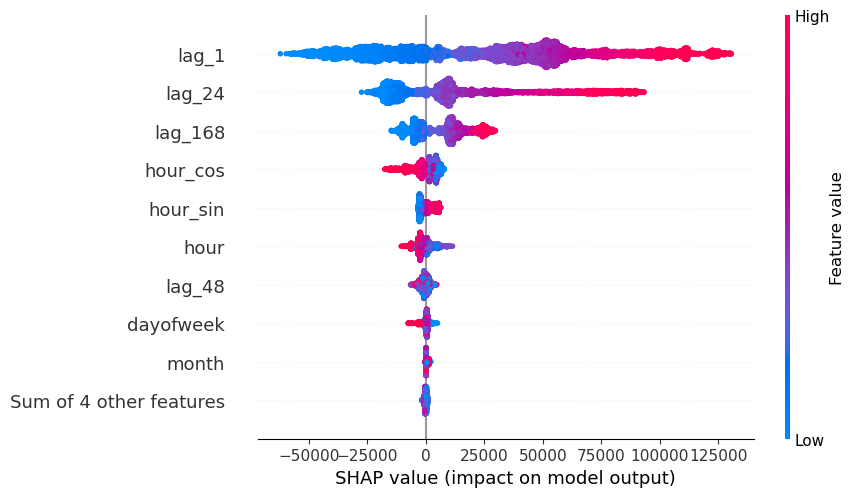

In [67]:
# Initial SHAP setup
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_val)

# Global importance summary
shap.plots.beeswarm(shap_values)


## Training a Neural Network (LSTM)
LSTM networks require tensors of shape (batch, time_steps, features). It is necessary to define a function that, given the dataset with lags, builds these windows. For simplicity, we can use the same features we defined earlier, although sometimes for LSTM the approach to lags is handled differently.

In [71]:
def create_sequences(X, y, time_steps=24):
    """
    time_steps: how many time steps back for the sequence.
    """
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24  # For example, use the past 24 hours to predict the next hour


## Building the Train/Validation/Test Sets for LSTM

In [74]:
# Make sure to remove NaN rows:
df_lstm = df_feat.dropna()

# Split in the same chronological way (we reuse the date indexes)
train_lstm = df_lstm.loc[:train_end_date]
val_lstm = df_lstm.loc[train_end_date:val_end_date]
test_lstm = df_lstm.loc[val_end_date:]

X_train_lstm, y_train_lstm = create_sequences(train_lstm[features], train_lstm['total_consumption'], time_steps=time_steps)
X_val_lstm, y_val_lstm     = create_sequences(val_lstm[features], val_lstm['total_consumption'], time_steps=time_steps)
X_test_lstm, y_test_lstm   = create_sequences(test_lstm[features], test_lstm['total_consumption'], time_steps=time_steps)

print(X_train_lstm.shape, y_train_lstm.shape)


(17376, 24, 13) (17376,)


## Defining the LSTM Model
Decisions:  
- 64 LSTM units.
- return_sequences=False since we only need the final output.
- Dropout(0.2) for regularization.
- Loss function: MSE.

In [79]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='tanh', return_sequences=False, input_shape=(time_steps, len(features))))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))  # Output layer

model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.summary()


C:\Users\luisj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,033 (78.25 KB)

 Trainable params: 20,033 (78.25 KB)

 Non-trainable params: 0 (0.00 B)

## Training and Validation 

Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 34379042816.0000 - val_loss: 56796196864.0000
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 34085830656.0000 - val_loss: 56793677824.0000
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 34314127360.0000 - val_loss: 56791158784.0000
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 34192623616.0000 - val_loss: 56788631552.0000
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 34342027264.0000 - val_loss: 56786112512.0000
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 33697259520.0000 - val_loss: 56783605760.0000
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 34473594880.0000 - val_loss: 56781090816.0000
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 34217908224.0000 - val_loss: 56778567680.0000
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 33482299392.0000 - val_loss: 56776065024.0000
Epoch 10/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 3s 10

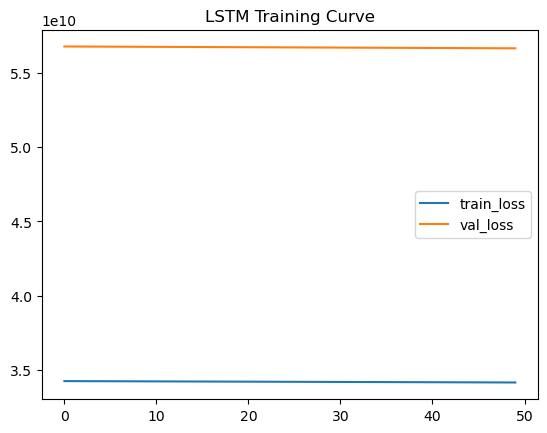

In [87]:
history = model_lstm.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=50,
    batch_size=64,
    verbose=1
)

# Plot training curve
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("LSTM Training Curve")
plt.show()


## Test Set Evaluation

In [89]:
test_pred_lstm = model_lstm.predict(X_test_lstm)

rmse_lstm = mean_squared_error(y_test_lstm, test_pred_lstm, squared=False)
mae_lstm = mean_absolute_error(y_test_lstm, test_pred_lstm)

print(f"LSTM - RMSE (Test): {rmse_lstm:.2f}")
print(f"LSTM - MAE  (Test): {mae_lstm:.2f}")


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM - RMSE (Test): 237772.85
LSTM - MAE  (Test): 224280.79


C:\Users\luisj\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Result Analysis 
- For LSTM: RMSE (Test): 237772.85  and MAE  (Test): 224280.79
- For XGBoost: RMSE (Test): 8742.59  and MAE (Test): 5875.24

An RMSE (Root Mean Squared Error) of 237772.85 for the LSTM means, on average, LSTM predictions deviate from the true values by that magnitude. In contrast, an RMSE of 874259 for XGBoost indicates it is making much more accurate predictions.
The MAE (Mean Absolute Error) of 224280.79 for LSTM vs. 587524 for XGBoost further confirms the large discrepancy. The LSTM is performing poorly (large errors) compared to XGBoost (relatively smaller errors). So for this type of projects the XGBoost could be considered a better model to use. In addition, LSTM model could be improved and hope to obtain better results by using data scaling, correct the overfitting or underfitting and adjusting the model accordinlgy  to get a better tuning.  
